# Data Science - Laboratorio 7
## Minería de Texto: Análisis de redes sociales

---
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

## Librerias

In [1]:
# Operaciones con datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

## Carga de Datasets

Se obtuvieron aproximadamente 5000 tweets de las cuentas de @traficogt y @BArevalodeLeon
hasta el 12 de septiembre de 2024. 
Cada registro de tweet tiene una estructura JSON que incluye metadatos como ID de
usuario, texto del tweet, menciones, retweets, y favoritos.

In [2]:
traficogt_df = pd.read_json('data/traficogt.txt', lines=True, encoding='utf-8')
tioberny_df = pd.read_json('data/tioberny.txt', lines=True, encoding='utf-8')

## Comprensión Inicial

### Información General del Dataset

In [3]:
def get_DF_info(df):
    """
    Función que genera un dataframe con información sobre las columnas de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    # Crear un dataframe con la información de las columnas
    info = pd.DataFrame({
        'Nombre Columna': df.columns,
        'Tipo de Dato': df.dtypes,
        'Valores Nulos (%)': (df.isnull().sum() * 100 / df.shape[0]).round(2),
        # Si la columna contiene dict o list, mostrar el tipo. Si no, calcular los valores únicos
        'Valores Únicos': df.apply(lambda x: 'dict' if x.apply(lambda y: isinstance(y, dict)).any() else 
                                             ('list' if x.apply(lambda y: isinstance(y, list)).any() else x.nunique()))
    }).reset_index(drop=True)

    # Mostrar la información del DataFrame
    print(f"\nEl DataFrame tiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas (variables)\n")
    display(info)

In [4]:
# Mostrar información del DataFrame de 'traficogt'
print("Información del dataset: traficogt.txt")
get_DF_info(traficogt_df)

Información del dataset: traficogt.txt

El DataFrame tiene 5605 filas (registros) y 32 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos
0,id,int64,0.00,5597
1,id_str,int64,0.00,5597
2,url,object,0.00,5597
3,date,"datetime64[ns, UTC]",0.00,5588
4,user,object,0.00,dict
5,lang,object,0.00,24
6,rawContent,object,0.00,5589
7,replyCount,int64,0.00,196
8,retweetCount,int64,0.00,350
9,likeCount,int64,0.00,502


In [5]:
# Mostrar información del DataFrame de 'tioberny'
print("Información del dataset: tioberny.txt")
get_DF_info(tioberny_df)

Información del dataset: tioberny.txt

El DataFrame tiene 5019 filas (registros) y 32 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos
0,id,int64,0.00,4944
1,id_str,int64,0.00,4944
2,url,object,0.00,4944
3,date,"datetime64[ns, UTC]",0.00,4896
4,user,object,0.00,dict
5,lang,object,0.00,20
6,rawContent,object,0.00,4933
7,replyCount,int64,0.00,116
8,retweetCount,int64,0.00,151
9,likeCount,int64,0.00,227


### Visualizar Dataframe

In [6]:
traficogt_df.head()

,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,coordinates,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type
0,1834236045598056867,1834236045598056960,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,NaN,NaN,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
1,1834029142565658846,1834029142565658880,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,NaN,NaN,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet
2,1834039491826180424,1834039491826180352,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,"{'id': 1730828822029750272, 'id_str': '1730828...",qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,...,NaN,NaN,NaN,"{'id': 130315077, 'id_str': '130315077', 'user...","<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
3,1833963729136091179,1833963729136091136,https://x.com/EstacionDobleA/status/1833963729...,2024-09-11 20:20:01+00:00,"{'id': 1802661334355456000, 'id_str': '1802661...",qam,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,...,NaN,1.833964e+18,1.833964e+18,"{'id': 1802661334355456000, 'id_str': '1802661...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
4,1833665391698092330,1833665391698092288,https://x.com/CubReserva/status/18336653916980...,2024-09-11 00:34:31+00:00,"{'id': 1155617398675988481, 'id_str': '1155617...",es,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,...,NaN,1.833664e+18,1.833664e+18,"{'id': 1155617398675988481, 'id_str': '1155617...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet


In [7]:
tioberny_df.head()

,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,coordinates,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type
0,1834281080029110288,1834281080029110272,https://x.com/La_ReVoluZzion/status/1834281080...,2024-09-12 17:21:03+00:00,"{'id': 1435062946598694914, 'id_str': '1435062...",es,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",0,0,0,...,NaN,NaN,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
1,1834252464092069901,1834252464092069888,https://x.com/XelaNewsGt/status/18342524640920...,2024-09-12 15:27:20+00:00,"{'id': 956650778634145792, 'id_str': '95665077...",es,#URGENTE Lo que los medios #faferos no informa...,12,80,142,...,NaN,NaN,NaN,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht...",None,snscrape.modules.twitter.Tweet
2,1834280919336976681,1834280919336976640,https://x.com/M24095273/status/183428091933697...,2024-09-12 17:20:25+00:00,"{'id': 1087057038755143680, 'id_str': '1087057...",es,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,0,0,0,...,NaN,1.834197e+18,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...","<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
3,1834280512933732694,1834280512933732608,https://x.com/carlosalbesc/status/183428051293...,2024-09-12 17:18:48+00:00,"{'id': 2881001877, 'id_str': '2881001877', 'ur...",es,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,0,0,0,...,NaN,1.834197e+18,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
4,1834279986254987428,1834279986254987520,https://x.com/Brenda_AGN/status/18342799862549...,2024-09-12 17:16:42+00:00,"{'id': 3013862206, 'id_str': '3013862206', 'ur...",es,El presidente @BArevalodeLeon y la vicepreside...,0,0,0,...,NaN,NaN,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,{'photos': [{'url': 'https://pbs.twimg.com/med...,None,snscrape.modules.twitter.Tweet


### Identificación de Variables

**Descripción de las variables del dataset `traficogt.txt`**

- `id`: Identificador numérico único del tweet.
- `id_str`: Identificador del tweet en formato string, que representa el mismo valor que `id`.
- `url`: URL del tweet en la plataforma `X` (anteriormente conocida como Twitter).
- `date`: Fecha y hora en que el tweet fue publicado.
- `user`: Información del usuario que publicó el tweet (un diccionario que incluye detalles como el nombre de usuario, seguidores, y más).
- `lang`: Idioma en el que está escrito el tweet.
- `rawContent`: Texto completo del tweet.
- `replyCount`: Número de respuestas al tweet.
- `retweetCount`: Número de retweets que ha recibido el tweet.
- `likeCount`: Número de "likes" que ha recibido el tweet.
- `quoteCount`: Número de veces que el tweet ha sido citado.
- `bookmarkedCount`: Número de veces que el tweet ha sido guardado en marcadores.
- `conversationId`: Identificador del hilo de conversación al que pertenece el tweet.
- `conversationIdStr`: Identificador en formato string del hilo de conversación al que pertenece el tweet.
- `hashtags`: Lista de hashtags incluidos en el tweet.
- `cashtags`: Lista de cashtags (etiquetas relacionadas con símbolos de acciones o monedas) en el tweet.
- `mentionedUsers`: Lista de usuarios mencionados en el tweet.
- `links`: Lista de enlaces incluidos en el tweet.
- `viewCount`: Número de visualizaciones del tweet.
- `retweetedTweet`: Información sobre el tweet retuiteado (puede estar vacío si el tweet no es un retweet).
- `quotedTweet`: Información del tweet citado (si el tweet cita a otro).
- `place`: Información geográfica del lugar desde donde se publicó el tweet (si está disponible).
- `coordinates`: Coordenadas geográficas (si están disponibles) del lugar donde se publicó el tweet.
- `inReplyToTweetId`: Identificador del tweet al que se respondió (si aplica).
- `inReplyToTweetIdStr`: Identificador en formato string del tweet al que se respondió.
- `inReplyToUser`: Información del usuario al que se le respondió (si aplica).
- `source`: Texto que describe la plataforma desde la cual se publicó el tweet (ej., "Twitter for iPhone").
- `sourceUrl`: URL de la plataforma desde la cual se publicó el tweet.
- `sourceLabel`: Etiqueta descriptiva de la plataforma desde la cual se publicó el tweet.
- `media`: Información multimedia asociada al tweet, como fotos o videos.
- `card`: Información relacionada con tarjetas de Twitter (por ejemplo, tarjetas de resumen de enlaces).
- `_type`: Tipo de entidad, que en este caso indica que es un tweet (valor fijo).



**Descripción de las variables del dataset `tioberny.txt`**

- `id`: Identificador numérico único del tweet.
- `id_str`: Identificador del tweet en formato string, que representa el mismo valor que `id`.
- `url`: URL del tweet en la plataforma `X` (anteriormente conocida como Twitter).
- `date`: Fecha y hora en que el tweet fue publicado.
- `user`: Información del usuario que publicó el tweet (un diccionario que incluye detalles como el nombre de usuario, seguidores, y más).
- `lang`: Idioma en el que está escrito el tweet.
- `rawContent`: Texto completo del tweet.
- `replyCount`: Número de respuestas al tweet.
- `retweetCount`: Número de retweets que ha recibido el tweet.
- `likeCount`: Número de "likes" que ha recibido el tweet.
- `quoteCount`: Número de veces que el tweet ha sido citado.
- `bookmarkedCount`: Número de veces que el tweet ha sido guardado en marcadores.
- `conversationId`: Identificador del hilo de conversación al que pertenece el tweet.
- `conversationIdStr`: Identificador en formato string del hilo de conversación al que pertenece el tweet.
- `hashtags`: Lista de hashtags incluidos en el tweet.
- `cashtags`: Lista de cashtags (etiquetas relacionadas con símbolos de acciones o monedas) en el tweet.
- `mentionedUsers`: Lista de usuarios mencionados en el tweet.
- `links`: Lista de enlaces incluidos en el tweet.
- `viewCount`: Número de visualizaciones del tweet.
- `retweetedTweet`: Información sobre el tweet retuiteado (puede estar vacío si el tweet no es un retweet).
- `quotedTweet`: Información del tweet citado (si el tweet cita a otro).
- `place`: Información geográfica del lugar desde donde se publicó el tweet (si está disponible).
- `coordinates`: Coordenadas geográficas (si están disponibles) del lugar donde se publicó el tweet.
- `inReplyToTweetId`: Identificador del tweet al que se respondió (si aplica).
- `inReplyToTweetIdStr`: Identificador en formato string del tweet al que se respondió.
- `inReplyToUser`: Información del usuario al que se le respondió (si aplica).
- `source`: Texto que describe la plataforma desde la cual se publicó el tweet (ej., "Twitter for iPhone").
- `sourceUrl`: URL de la plataforma desde la cual se publicó el tweet.
- `sourceLabel`: Etiqueta descriptiva de la plataforma desde la cual se publicó el tweet.
- `media`: Información multimedia asociada al tweet, como fotos o videos.
- `card`: Información relacionada con tarjetas de Twitter (por ejemplo, tarjetas de resumen de enlaces).
- `_type`: Tipo de entidad, que en este caso indica que es un tweet (valor fijo).


## Preprocesamiento y Limpieza

### Valores Nulos

In [8]:
def plot_null_values(df, name):
    """
    Función que genera un gráfico de barras con los valores nulos de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title(f'Valores Nulos en archivo {name}')
    plt.show()

#### Verificación valores nulos

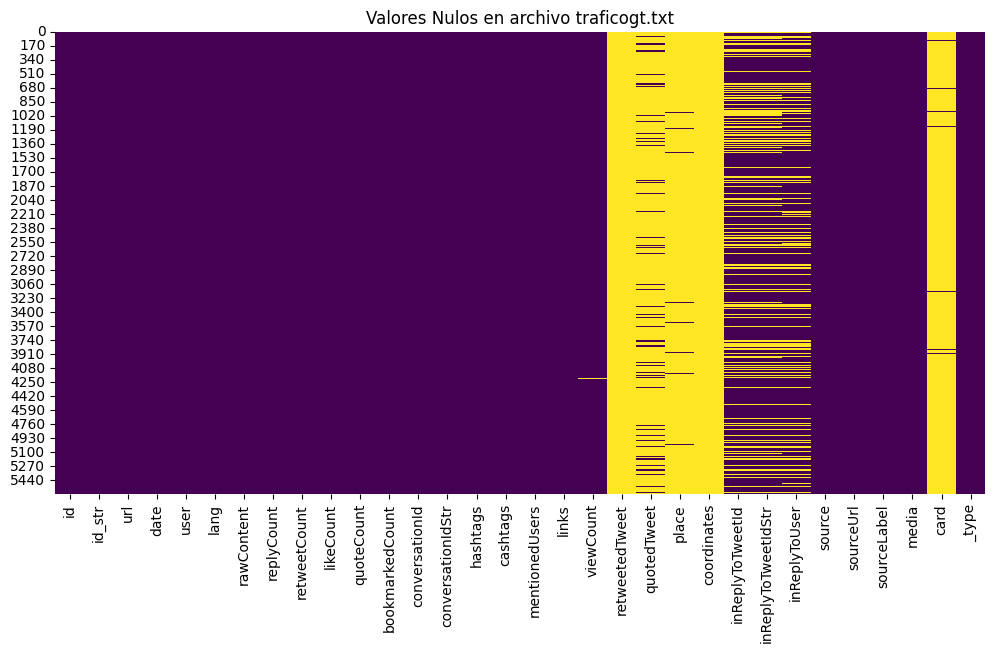

In [9]:
plot_null_values(traficogt_df, 'traficogt.txt')

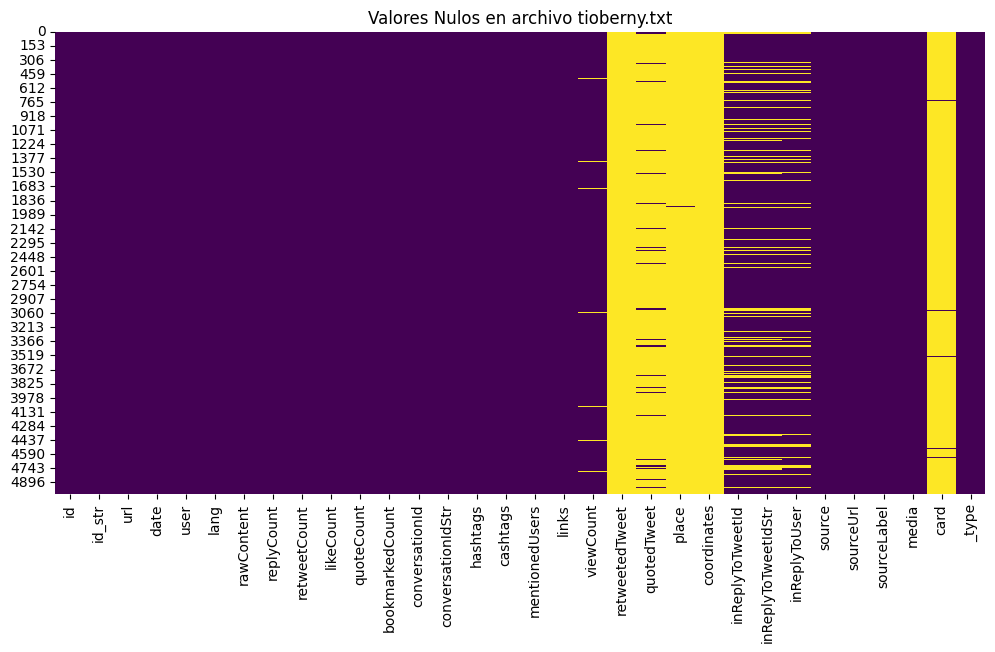

In [10]:
plot_null_values(tioberny_df, 'tioberny.txt')

Ambos graficos ayudan a visualizar la distribucion de los datos en el conjunto de datos de traficogt.txt y de tioberny.txt
Es claro que ambos conjuntos de datos presentan un mismo "comportamiento" en cuanto a nulos se refiere.

Es posible observar que hay ciertas columnas que no tienen datos en lo absoluto y otras que tienen una parte de ellos faltantes.

**Columnas con muchos nulos**
- `retweetedTweet`, `coordinates`, `place`, `media`, `card`, `source`. Estas variables tienen practicamente la totalidad de sus datos faltantes, y no son de utilidad para este estudio por lo que sera mas fácil, eliminarlas del conjunto de datos.

Por otra parte hay algunas columnas que tienen cierta cantidad de nulos pero que dada la naturaleza de este estudio, pueden ser variables potencialmente utiles.
**Columnas con algunos nulos**
- `inReplyToTweetId`, `inReplyToUser`, `quotedTweet`. Estas variables se van a dejar y manejar los nulos reemplazandolos por algun tipo de string que identifica que no aplica.
- Sin embargo, la retencion de estas sera analizada mas adelante en este analisis.

#### Eliminar Columnas con Muchos Valores Nulos

In [17]:
# Definir las columnas que se desean eliminar
columns_to_drop = ['retweetedTweet', 'coordinates', 'place', 'media', 'card', 'source', 'inReplyToTweetId', 'inReplyToUser', 'quotedTweet']

# Eliminar las columnas en ambos datasets, ignorando errores si alguna columna no existe
traficogt_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
tioberny_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Verificar que las columnas hayan sido eliminadas
print("Columnas eliminadas exitosamente.")


Columnas eliminadas exitosamente.


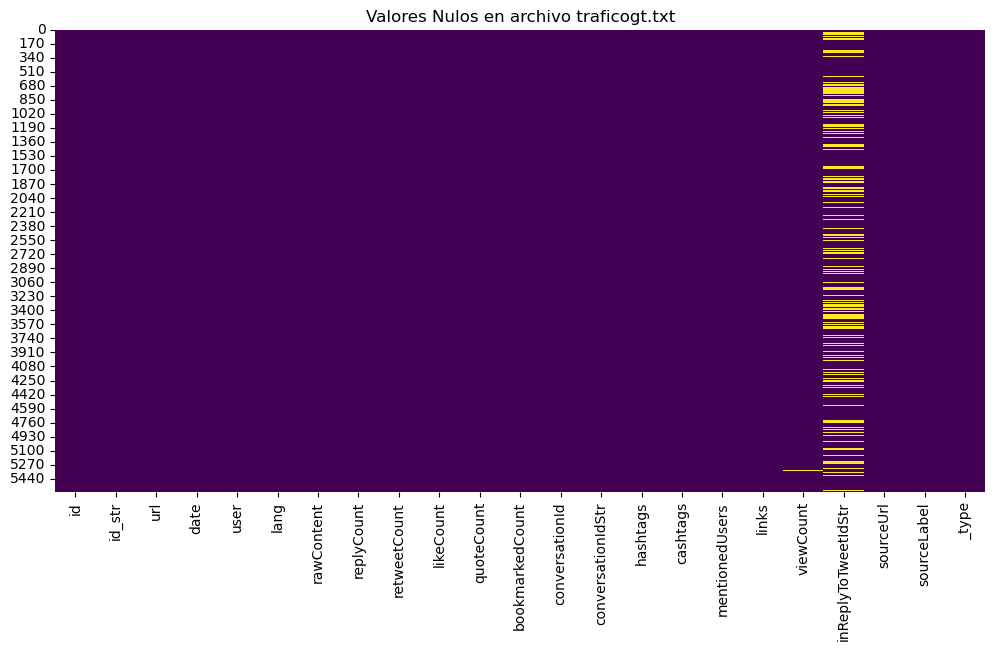

In [18]:
plot_null_values(traficogt_df, 'traficogt.txt')

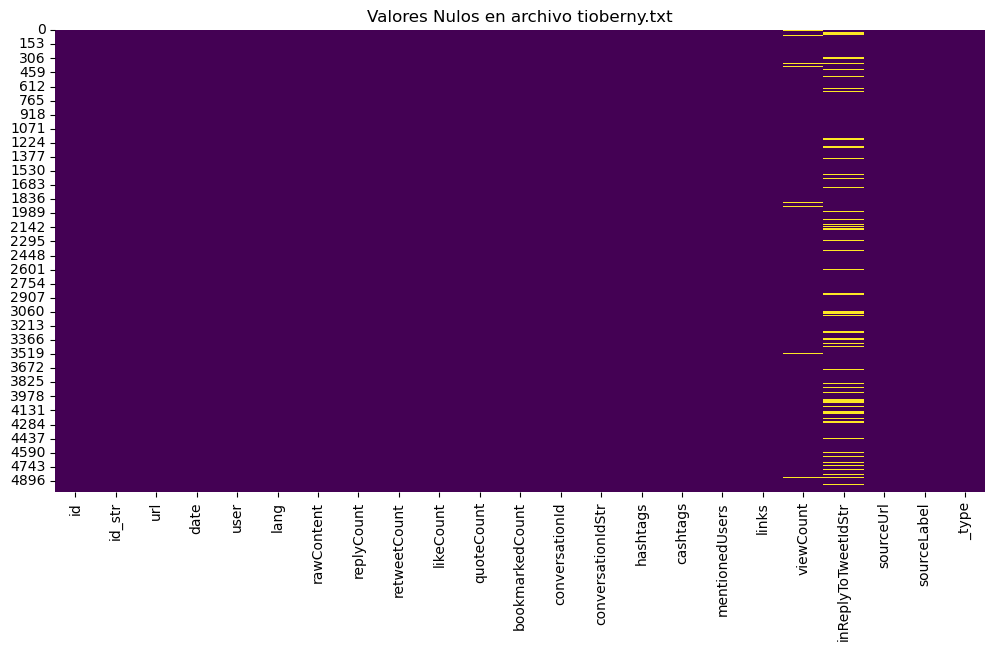

In [19]:
plot_null_values(tioberny_df, 'tioberny.txt')